In [1]:
import numpy as np
import utils
from skimage.filters import window
from scipy.signal import convolve2d

## 1. Zero-Filled Fourier Reconstruction and Half-Fourier Reconstruction

### 1-1. Load the dataset `kdata_phase_error_severe.mat`, which was acquired with a PF (Partial Fourier) factor of 9/16.

In [2]:
mat = utils.load_data('kdata_phase_error_severe.mat')
kdata = mat['kdata']

kx, ky = kdata.shape # kx: Read out, ky: Phase encode
PF = 9/16
print(kx,ky)

512 288


### 1-2-1. Compute the zero-filled Fourier reconstruction.


In [3]:

full_y = int (ky*(1/PF))
print(full_y)
zf_kspace= np.zeros((kx,full_y),dtype=kdata.dtype ) 
zf_kspace[:,:full_y//2]= kdata[:,:full_y//2]
zero_recon= utils.ifft2c(zf_kspace)


512


### 1-2-2. Compute  the theoretical half-Fourier reconstruction (Hermitian symmetry only, no phase-correction).


In [4]:
half_fourier1 = zf_kspace
half_fourier2= zf_kspace[:,:full_y//2]
half_fourier3= np.flip(half_fourier2)
half_fourier = np.concatenate((half_fourier2,half_fourier3),dtype=kdata.dtype,axis=1)
half_recon= utils.ifft2c(half_fourier)



### 1-2-3. Plot the zero-filled kdata and the theoretical half-Fourier kdata side-by-side as well as their reconstructions.

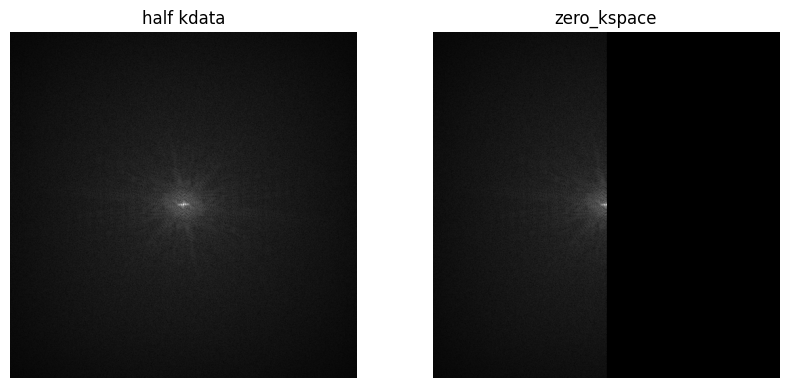

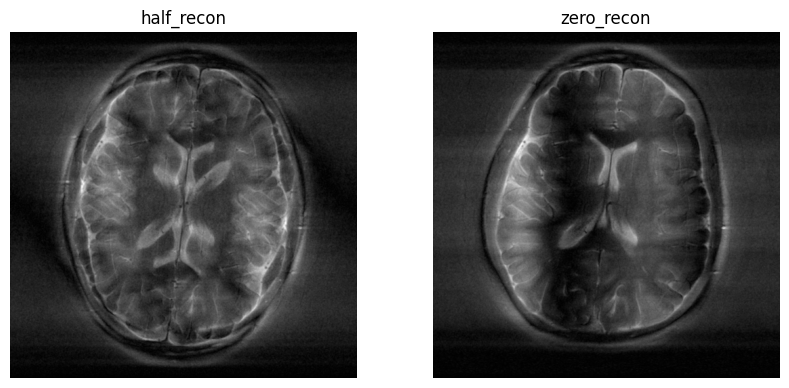

In [5]:

utils.imshow([half_fourier,zf_kspace],titles=["half kdata","zero_kspace"],norm=0.3)
utils.imshow([half_recon,zero_recon],titles=["half_recon","zero_recon"])


## 2. Phase Estimation Function

### 2-1 Define a function "estim_phs()"
$$e^{-i \angle (I_c(r))}$$
$$\angle I_c(r) = \angle(\mathfrak{F}^{-1}(W_c(k) * S_c(k)))$$


In [6]:
def estim_phs(kspace, full_ky):
    '''
        Phase estimation

        Param:
            kspace:             asymmetric k-space data
            full_ky:            target size of the reconstructed PF dimension
        Return:
            estimated_phase:    estimated phase of the input "kspace"
    '''
   
    #take middle of kspace
    kx,ky=kspace.shape
    phase_ref_size=(ky-full_ky//2)*2
    hamm=window('hamming',(kx,phase_ref_size))
    phase_ref_k=np.zeros((kx,full_ky),dtype=kspace.dtype)
    phase_ref_k[:,ky-phase_ref_size:ky]=kspace[:,ky-phase_ref_size:ky]*hamm
    phase=utils.ifft2c(phase_ref_k)
    phase=np.angle(phase)
    return phase

### 2-2 Estimate the phase of the zero-filled kdata

In [7]:

phs_estim=estim_phs(kdata,full_y)


### 2-3 Plot estimated phase

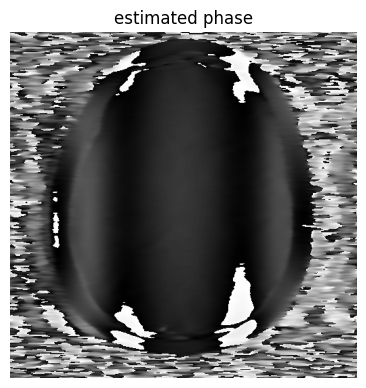

In [8]:

utils.imshow([phs_estim],titles=["estimated phase"],is_mag=False)

## 3. Margosian Partial Fourier Reconstruction Function


### 3-1-1 Define a function returning a window of type either ramp and hamming

In [9]:
def get_window(kdata, full_ky, type='ramp'):
    '''
    This function returns the window for the Hermitian symmetric extension

    Param:
        kdata:          asymmetric k-space data
        full_ky:        target size of the reconstructed PF dimension
        type:           filter type ('ramp' or 'hamm')
    Return:
        filter:         filter for the Hermitian symmetric extension
    '''
    
    kx, ky = kdata.shape
    sym_gap = (ky - full_ky // 2) * 2
    filter_start, filter_end = (full_ky - sym_gap) // 2, (full_ky + sym_gap) // 2

    window_frame = np.zeros((kx, full_ky), dtype=kdata.dtype)
    window_frame[:, :filter_start] = np.ones((kx, filter_start))
    
    if type == 'ramp':
        filter_part = np.linspace(1, 0, sym_gap, dtype=kdata.dtype)
        filter_part = np.tile(filter_part, (kx, 1))
    elif type == 'hamming':
        filter_part = np.hamming(sym_gap * 2)
        filter_part = np.tile(filter_part, (kx, 1))[:, sym_gap:]
        filter_part -= np.min(filter_part)
        filter_part /= np.max(filter_part)

    window_frame[:, filter_start:filter_end] = filter_part

    return window_frame


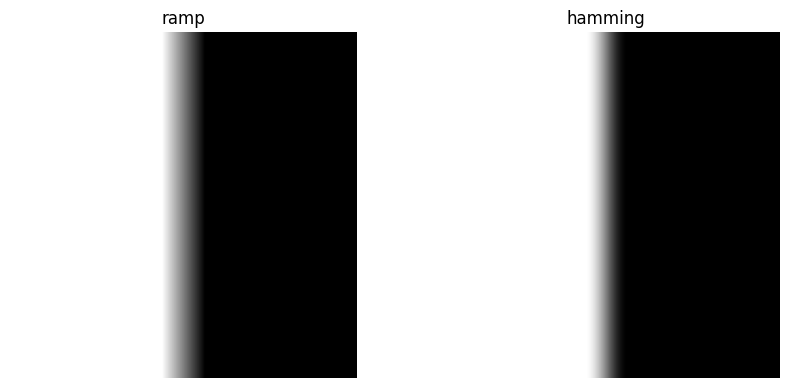

In [10]:
ramp_window_= get_window(kdata,full_y)
hamm_window = get_window(kdata,full_y,'hamming')
utils.imshow([ramp_window_,hamm_window],titles=["ramp","hamming"])


### 3-1-2 Define a function "pf_margosian(kdata, full_ky, wtype)"

In [10]:
def pf_margosian(kdata, full_ky, wtype):
    '''
        Margosian reconstruction for partial Fourier (PF) MRI

        Param:
            kdata:      asymmetric k-space data
            full_ky:    target size of the reconstructed PF dimension
            wtype:      The type of window ('ramp' or 'hamm')

        Return:
            I: reconstructed magnitude image
    '''
  
    #left
    kx,ky=kdata.shape                   
    phs_estim=estim_phs(kdata,full_ky)

    #right
    ramp_window_= get_window(kdata,full_ky,'ramp')
    
    hamm_window= get_window(kdata,full_ky,'hamming')

    zf_kspace= np.zeros((kx,full_ky),dtype=kdata.dtype ) 
    zf_kspace[:,:ky]= kdata
    
    if wtype=='ramp':
        zf_kspace*=ramp_window_
    elif wtype=='hamming':
        zf_kspace*=hamm_window
        
    io=utils.ifft2c(zf_kspace)
    #sum
    final=np.real(io* np.exp(-1j*(phs_estim)))
    return final

### 3-2 Margosian Reconstruction with Filters
Perform Margosian reconstruction using both ramp and Hamming filters on the kdata dataset, then plot them.


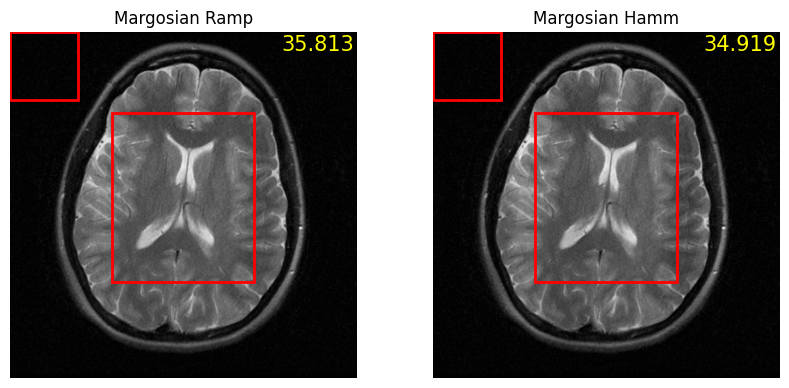

In [22]:

margosian_ramp=pf_margosian(kdata,full_y,'ramp')
margosian_hamm=pf_margosian(kdata, full_y,'hamming')
utils.imshow([margosian_ramp,margosian_hamm],titles=["Margosian Ramp","Margosian Hamm"],snr=True)

### 3-2 Discuss the results between the two filters in terms of SNR and potential artifacts.
$$ SNR = \frac{\mu_{signal}}{\sigma_{noise}}$$

## 4. POCS Partial Fourier Reconstruction Function


### 4-1 Define a function "pf_pocs(kdata, full_ky, niter)"

In [17]:
def pf_pocs(kdata, full_ky, Nite):
    '''
        POCS reconstruction for partial Fourier (PF) MRI

        Param:
            kdata:      asymmetric k-space data
            full_ky:    size of the reconstructed PF dimension
            Nite:       number of iterations
            
        Return:
            I: reconstructed magnitude image
    '''
    phase_estim = estim_phs(kdata, full_ky)
    kx, ky = kdata.shape

    # Initialize zero-filled k-space
    zf_kspace12 = np.zeros((kx, full_ky), dtype=kdata.dtype)
    zf_kspace12[:, :ky] = kdata
    
    
        # Estimate the phase of the current reconstruction
    for i in range(Nite):

       
        recon = utils.ifft2c(zf_kspace12)
        zf_kspace1= np.abs(recon) * np.exp(1j*phase_estim)

        zf_kspace= utils.fft2c(zf_kspace1)
        zf_kspace12[:,:full_y]= zf_kspace[:,:full_y]
        
    

### 4-2 POCS Reconstruction with Iterations
- iterations: 2, 4, 6, 8, 10


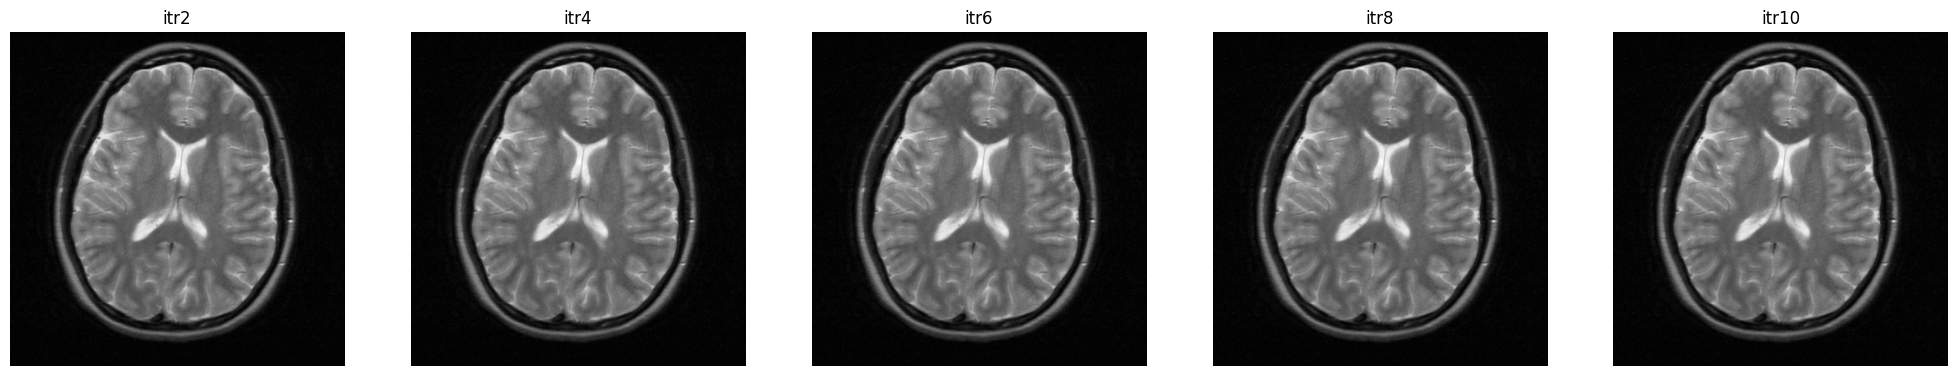

In [18]:

#every itr we add another noise as phase estmn has noise as well. we did not consider that noise
pocs2=pf_pocs(kdata, full_y,Nite=2)


pocs4=pf_pocs(kdata, full_y,Nite=4)


pocs6=pf_pocs(kdata, full_y,Nite=6)


pocs8=pf_pocs(kdata, full_y,Nite=8)


pocs10=pf_pocs(kdata, full_y,Nite=10)
utils.imshow([pocs2,pocs4,pocs6,pocs8,pocs10],titles=["itr2","itr4","itr6","itr8","itr10"])

### 4-3 Find convergence of the POCS algorithm
Choose the minimum number of iterations where the algorithm has converged by comparing reconstructed images to each other. Hint: when comparing reconstructed images, do not forget to normalize images in a range of 0-1. Plot the change in the solution with respect to the number of iterations.

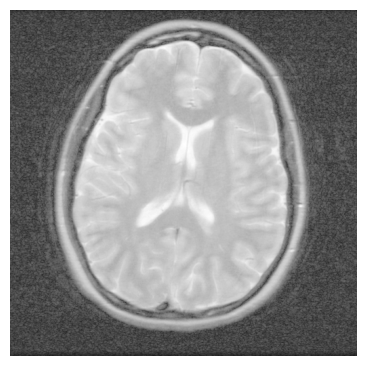

In [19]:


pocs2=pf_pocs(kdata, full_y,Nite=20)
utils.imshow([pocs2],norm=0.3)

## 5. Comparison of Reconstructions
### 5-1 For the partial Fourier dataset, plot the zero-filled FFT, Margosian, and POCS reconstructions.


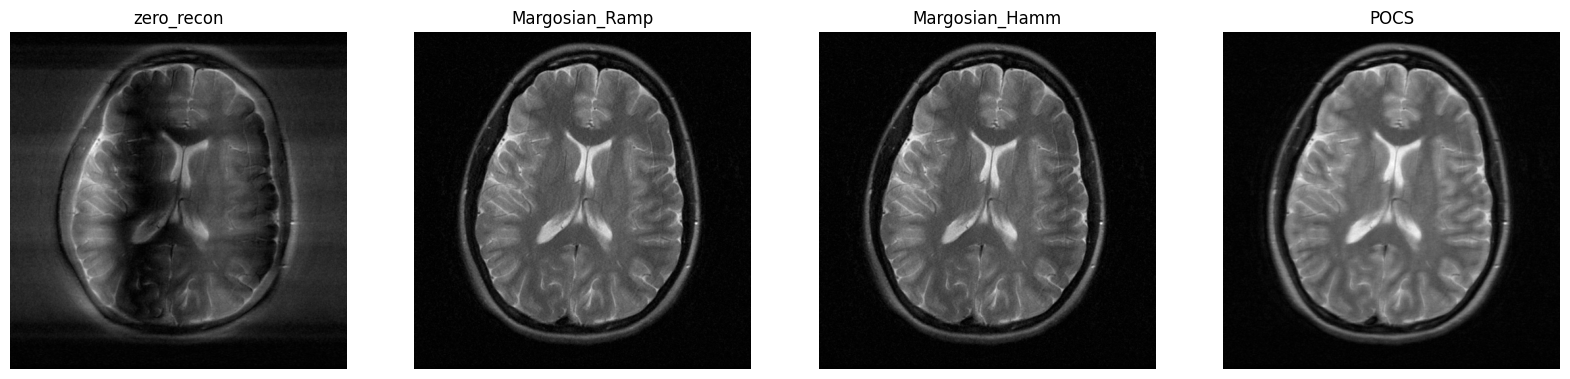

In [20]:

utils.imshow([zero_recon,margosian_ramp,margosian_hamm,pocs2],titles=["zero_recon","Margosian_Ramp","Margosian_Hamm","POCS"])